In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Initialization***

In [308]:
# Importing some library files...
import sklearn
import pandas as pd
import numpy as np
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from pandas.core.dtypes.common import is_numeric_dtype
import pickle
from google.colab import files
import random
import warnings as wr
wr.filterwarnings('ignore')

# Importing ALL THE MODELS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
# imagine ANN imports here #
import lightgbm as lgb

# Importing evaluation metrics
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.neighbors import NearestNeighbors
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [309]:
# Fetching the Dataset for training...
path = "/content/drive/MyDrive/Colab Notebooks/linkdin_Job_data7000.csv"
df = pd.read_csv(path)
print(len(df))
df.head()

7927


,job_type,work_type,job_details
0,"Data Analyst, Trilogy (Remote) - $60,000/year USD",Remote,About the job Crossover is the world's #1 sour...
1,"Data Analyst, Trilogy (Remote) - $60,000/year USD",Remote,About the job Crossover is the world's #1 sour...
2,Data Analyst - WFH,Remote,About the job Profile: ML EngineersExperience:...
3,Data Analyst,On-site,About the job Designation: Data AnalystLocatio...
4,Data Analyst,On-site,About the job The ideal candidate will use the...


In [310]:
target = 'job_type'

# ***Dataset Preprocessing***

***Dataset Cleaning***

In [311]:
print(len(df[target].unique()))
df = df.dropna() # Dropping Nulls
print(len(df[target].unique()))

# Cleaning Class Names
def clean_class_name(class_name):
    class_name = class_name.split(',')[0]
    class_name = class_name.split(' -')[0]
    class_name = class_name.split('|')[0]
    class_name = class_name.split('(')[0]
    class_name = class_name.split('[')[0]
    return class_name.strip()  # Strip to remove leading/trailing spaces

df[target] = df[target].apply(clean_class_name)
print(len(df[target].unique()))

2992
2924
2556


***Class Sampling***

In [312]:
# Class Sample Report

col1 = 'Class_Name'
col2 = 'Class_Count'
col3 = 'Cumulative_Count'
col4 = 'Class_Count_To_Cumulative_Count_Ratio(%)'

class_sample_report = {
    col1 : [],
    col2 : [],
    col3 : [],
    col4 : []
}

# Count occurrences of each class in the 'Class' column
class_counts = df[target].value_counts()
sorted_classes = class_counts.sort_values(ascending=False)

# #
cumulative_count = 0
for class_label, count in sorted_classes.items():
    class_sample_report[col1].append(class_label)
    class_sample_report[col2].append(count)
    cumulative_count += count
    class_sample_report[col3].append(cumulative_count)
    class_sample_report[col4].append(f"{(count/cumulative_count)*100:.2f}%")

class_sample_report = pd.DataFrame(class_sample_report)

In [313]:
class_sample_report.head(60)

,Class_Name,Class_Count,Cumulative_Count,Class_Count_To_Cumulative_Count_Ratio(%)
0,Data Engineer,199,199,100.00%
1,Business Analyst,184,383,48.04%
2,Lead Java Software Engineer,171,554,30.87%
3,Senior Automation Tester,146,700,20.86%
4,Lead Java Developer,120,820,14.63%
5,Data Analyst,119,939,12.67%
6,Lead Automation Tester,116,1055,11.00%
7,Python Developer,113,1168,9.67%
8,Senior Java Software Engineer,101,1269,7.96%
9,Lead .NET Developer,68,1337,5.09%


In [314]:
# Choosing classes which has too few samples and will be dropped

# Get the classes with low number of members
classes_to_drop = class_counts[class_counts <= 41].index

# Filter the DataFrame based on classes to drop
df = df[~df[target].isin(classes_to_drop)]
print(len(df))

2041


***Feature Engineering***

In [316]:
skills = [
    "python", "sql", "aws", "data analysis", "communication", "financial analysis", "recruiting",
    "training", "performance management", "advertising", "tableau", "marketing", "excel",
    "sales", "digital marketing", "css", "project management", "html", "writing",
    "content creation", "sem", "social media", "javascript", "erp", "critical thinking",
    "analytics", "crm", "research", "seo", "design", "artificial intelligence",
    "machine learning", "compliance", "accounting", "forecasting", "leadership",
    "audit", "risk management", "legal", "budgeting", "databases", "teamwork", "java",
    "linux", "windows", "network security", "agile", "scrum", "spring", "hibernate",
    "supply chain", "logistics", "operations management", "negotiation", "cisco",
    "quality assurance", "human resources", "business development", "c++", "git",
    "data science", "big data", "deep learning", "hadoop", "spark", "etl",
    "data warehousing", "mysql", "sql server", "docker", "kubernetes", "ci/cd",
    "jenkins", "electrical engineering", "autocad", "matlab", "power systems", "circuit design",
    "organizational skills", "administrative skills", "microsoft office", "react", "angular",
    "web development", "ux/ui design", "safety", "compliance", "auditing", "environmental health",
    "process improvement", "lean manufacturing", "six sigma", "interior design", "3d modeling",
    "photoshop", "financial analysis", "investment strategies", "economics", "troubleshooting",
    "itil", "hardware support", "laboratory skills", "quality control", "chemistry", "biology",
    "instrumentation", "legal research", "transportation management", "planning", "pharmaceutical industry",
    "medical knowledge", "patient care", "healthcare", "time management", "organization",
    "legal documentation", "prototyping", "product development", "creativity", "technical documentation",
    "graphic design", "user research", "fabrication", "metalworking", "blueprint reading",
    "mig/tig welding", "yoga teaching", "fitness", "health and wellness", "flexibility training"
]

skills = list(set(skills))

for skill in skills:
    tmplist = []
    for detail in df["job_details"]:
      tmptext = detail.lower().translate(str.maketrans('', '', string.punctuation)).split(' ')
      flag=0;
      for word in tmptext:
        if word == skill:
          flag=1
          break
      tmplist.append(flag)
    df[skill]=tmplist

df = df.drop("job_details", axis=1)
le = LabelEncoder()
df['work_type'] = le.fit_transform(df['work_type'])

In [317]:
# Define Gini index function
def gini_index(feature):
    # Get unique values in feature
    values = df[feature].unique()
    # Calculate proportion of each value
    proportions = []
    for value in values:
        proportion = len(df[df[feature] == value]) / len(df)
        proportions.append(proportion)
    # Calculate Gini index
    gini = 1 - sum([p**2 for p in proportions])
    return gini

gini_scores = {}
gini_scores['work_type'] = gini_index('work_type')
for feature in skills:
    gini_scores[feature] = gini_index(feature)

# Initialize List with feature names with Gini value 0
features_to_drop = []

gini_scores_reverse = {}

for feature, gini_score in sorted(gini_scores.items(), key=lambda x: x[1], reverse=True):
  gini_scores_reverse[gini_score] = []

for feature, gini_score in gini_scores.items():
  gini_scores_reverse[gini_score].append(feature)

print("Gini Score"," : ","Feature Names")
for gini_score, feature_names in gini_scores_reverse.items():
  print(gini_score," : ", end = ""), print(*feature_names, sep = ", ")

Gini Score  :  Feature Names
0.5425849939061586  : work_type
0.49231710253377536  : communication
0.46512923097087844  : design
0.4531139086262247  : aws
0.39818699511556455  : java
0.39685612028381434  : sql
0.38636563865548035  : agile
0.38069069619109097  : leadership
0.37092518606201486  : python
0.30610121130254586  : javascript
0.25214508744188513  : analytics
0.22596065325213344  : git
0.22232139234857384  : spring
0.20527159904947112  : scrum
0.19080385656030785  : jenkins, docker
0.18460847097989497  : organization
0.16725428567381906  : databases
0.16645441645675696  : spark
0.16163503638420718  : writing
0.1559687359641797  : planning
0.15189257170676296  : kubernetes
0.1486143562121056  : marketing
0.13618421573807504  : etl
0.12693146690781165  : compliance
0.1226872628989113  : training
0.12012921776775509  : research
0.1158466046728015  : sales
0.10198092460752517  : hadoop
0.09671791959105835  : react, troubleshooting
0.09583739129328439  : excel
0.08608820502578074  : 

In [318]:
# Choosing one feature among many with same gini

for gini_score, feature_names in gini_scores_reverse.items():
  if gini_score == 0:
    unselected_features = feature_names
  else:
    selected_feature = random.choice(feature_names)
    unselected_features = [feature for feature in feature_names if feature != selected_feature]
  if len(unselected_features):
    print(*unselected_features, sep=",")
  features_to_drop.extend(unselected_features)

docker
react
legal
css,negotiation
budgeting
seo
auditing,fitness
legal documentation,supply chain,health and wellness,autocad,user research,performance management,sql server,quality assurance,c++,business development,microsoft office,administrative skills,fabrication,hardware support,product development,web development,risk management,power systems,data warehousing,data science,medical knowledge,pharmaceutical industry,content creation,graphic design,patient care,lean manufacturing,technical documentation,metalworking,mig/tig welding,blueprint reading,financial analysis,network security,organizational skills,artificial intelligence,human resources,laboratory skills,digital marketing,photoshop,matlab,ci/cd,data analysis,3d modeling,sem,deep learning,critical thinking,project management,interior design,machine learning,social media,six sigma,circuit design,flexibility training,environmental health,quality control,process improvement,electrical engineering,legal research,biology,transpor

,job_type,work_type,instrumentation,java,aws,communication,crm,kubernetes,healthcare,teamwork,...,leadership,spark,writing,training,cisco,excel,etl,scrum,planning,recruiting
7824,PL/SQL Developer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7830,PL/SQL Developer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7896,Senior Data Engineer,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7897,Python Developer,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7921,Python Developer,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Drop columns in 'gini_scores'
for feature in features_to_drop:
  del gini_scores[feature]

# Drop columns in 'skills' array
print(len(skills))
skills = [skill for skill in skills if skill not in features_to_drop]
print(len(skills))

# Drop columns in 'df' dataframe
df.drop(columns=features_to_drop, inplace=True)
df.tail()

***Train Test Split***

In [319]:
y = df[target]
X = df.drop(target, axis=1)
X.describe()

,work_type,instrumentation,java,aws,communication,crm,kubernetes,healthcare,teamwork,jenkins,...,leadership,spark,writing,training,cisco,excel,etl,scrum,planning,recruiting
count,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,...,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000,2041.000000
mean,1.476727,0.000980,0.274375,0.346889,0.438021,0.015679,0.082803,0.038217,0.014699,0.106810,...,0.255757,0.091622,0.088682,0.065654,0.000490,0.050465,0.073493,0.116120,0.085252,0.026458
std,0.723263,0.031296,0.446308,0.476097,0.496265,0.124259,0.275651,0.191766,0.120373,0.308948,...,0.436393,0.288562,0.284354,0.247737,0.022135,0.218957,0.261009,0.320447,0.279325,0.160531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [320]:
# Splitting Data into Train and Test Sets...
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

In [321]:
# Checking sample count for each class
class_counts = y_train.value_counts()
sorted_classes = class_counts.sort_values(ascending=False)

# Print unique classes and their counts in descending order
print("Unique classes in descending order of count:")
for class_label, count in sorted_classes.items():
    print(f"Class: {class_label}, Count: {count}")

Unique classes in descending order of count:
Class: Data Engineer, Count: 149
Class: Business Analyst, Count: 138
Class: Lead Java Software Engineer, Count: 128
Class: Senior Automation Tester, Count: 109
Class: Lead Java Developer, Count: 90
Class: Data Analyst, Count: 89
Class: Lead Automation Tester, Count: 87
Class: Python Developer, Count: 85
Class: Senior Java Software Engineer, Count: 76
Class: Lead .NET Developer, Count: 51
Class: Senior Test Automation Engineer, Count: 48
Class: Senior Data Engineer, Count: 47
Class: Salesforce Developer, Count: 45
Class: Senior ReactJS Developer, Count: 43
Class: Data Scientist, Count: 43
Class: Azure Data Engineer, Count: 42
Class: Senior Business Analyst, Count: 42
Class: Java Team Lead, Count: 41
Class: PL/SQL Developer, Count: 40
Class: Lead Test Automation Engineer, Count: 37
Class: Human Resources Intern, Count: 34
Class: Senior Analyst, Count: 34
Class: Senior Developer, Count: 32


In [322]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data only
X_train, y_train = smote.fit_resample(X_train, y_train)
print(len(X_train))
print(len(X_train))

3427
3427


In [323]:
# Checking sample count for each class
class_counts = y_train.value_counts()
sorted_classes = class_counts.sort_values(ascending=False)

# Print unique classes and their counts in descending order
print("Unique classes in descending order of count:")
for class_label, count in sorted_classes.items():
    print(f"Class: {class_label}, Count: {count}")

Unique classes in descending order of count:
Class: Lead Java Software Engineer, Count: 149
Class: Data Analyst, Count: 149
Class: Lead Automation Tester, Count: 149
Class: Senior Developer, Count: 149
Class: Business Analyst, Count: 149
Class: Senior Java Software Engineer, Count: 149
Class: Senior Business Analyst, Count: 149
Class: Lead Java Developer, Count: 149
Class: Data Engineer, Count: 149
Class: Salesforce Developer, Count: 149
Class: Azure Data Engineer, Count: 149
Class: Lead .NET Developer, Count: 149
Class: Lead Test Automation Engineer, Count: 149
Class: Senior Data Engineer, Count: 149
Class: Senior ReactJS Developer, Count: 149
Class: Python Developer, Count: 149
Class: Data Scientist, Count: 149
Class: Senior Automation Tester, Count: 149
Class: Senior Test Automation Engineer, Count: 149
Class: Java Team Lead, Count: 149
Class: Human Resources Intern, Count: 149
Class: PL/SQL Developer, Count: 149
Class: Senior Analyst, Count: 149


In [325]:
X_test2 = X_test[:1]
X_test2

,work_type,instrumentation,java,aws,communication,crm,kubernetes,healthcare,teamwork,jenkins,...,leadership,spark,writing,training,cisco,excel,etl,scrum,planning,recruiting
2567,2,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Initializing Model Comparators***

In [326]:
#lists initiated that will contain the name of the models and their respective metrics
names = []
scores = []
cross_scores = []
f1=[]
pr=[]

# ***KNN***

In [327]:
classifier = KNeighborsClassifier() # n_neighbors = 5
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
# y_pred

In [328]:
y_pred2 = classifier.predict(X_test2)
y_pred2

array(['Salesforce Developer'], dtype=object)

In [329]:
# Evaluating KNN for Classification...
acc =  classifier.score(X_test, y_test)
print(acc)

0.6868884540117417


Text(0, 0.5, 'F1 Score')

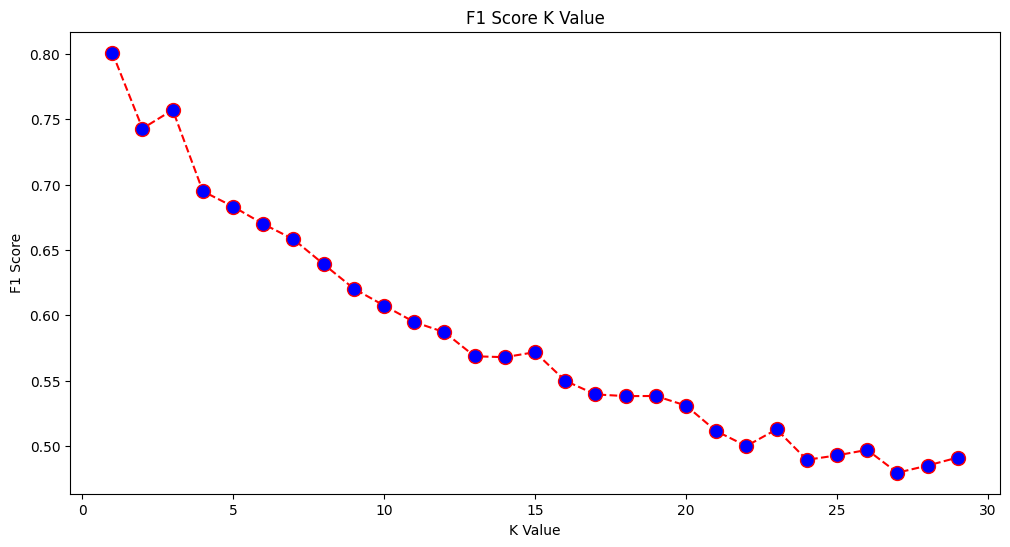

In [330]:
# ============================================
# Finding the Best K for KNN Classification...
# ============================================

f1s_KNN = []

# Calculating f1 score for K values between 1 and 30
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # average='weighted' to calculate a weighted average for the classes
    f1s_KNN.append(f1_score(y_test, pred_i, average='weighted'))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), f1s_KNN, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

In [331]:
# The f1-score is the highest when the value of the K is...
# Retrain the classifier with best k neighbors...
classifier_best = KNeighborsClassifier(n_neighbors=5)
classifier_best.fit(X_train, y_train)
y_pred_best = classifier_best.predict(X_test)
#print(classification_report(y_test, y_pred_best))

In [332]:
y_pred2_best = classifier_best.predict(X_test2)
y_pred2_best

array(['Salesforce Developer'], dtype=object)

In [333]:
# Evaluating KNN for Classification...
acc =  classifier_best.score(X_test, y_test)
print(acc)

0.6868884540117417


In [334]:
knn_acc = accuracy_score(y_test, y_pred_best)
print("KNN accuracy:", knn_acc)
knn_accuracy = cross_val_score(classifier_best,X_test,y_test,scoring='accuracy')
print("Cross-Validation Accuracy:", knn_accuracy.mean())
prv = precision_score(y_test,y_pred,average='weighted')
print("Precision:", prv)
f1v = f1_score(y_test,y_pred,average='weighted')
print("F1 Score:", f1v)

names.append('KNN')
scores.append(knn_acc)
cross_scores.append(knn_accuracy.mean())
pr.append(prv)
f1.append(f1v)

KNN accuracy: 0.6868884540117417
Cross-Validation Accuracy: 0.46569579288025886
Precision: 0.7131215873658453
F1 Score: 0.6831576065245774


In [335]:
# Visualize using a heatmap....
from sklearn.metrics import classification_report, confusion_matrix
#importing Seaborn's to use the heatmap
import seaborn as sns

#*********

all_classes = y_train.unique()

# Create an empty confusion matrix of size 105x105 (assuming 105 classes)
conf_matrix = np.zeros((len(all_classes), len(all_classes)))

# Compute confusion matrix using y_test and y_pred
cm = confusion_matrix(y_test, y_pred, labels=all_classes)

# Fill the corresponding part of the empty confusion matrix with computed values
conf_matrix[:cm.shape[0], :cm.shape[1]] = cm

# Convert the confusion matrix to a DataFrame for better readability (optional)
cm = pd.DataFrame(conf_matrix, index=all_classes, columns=all_classes)

cm_int = cm.astype(int)

# Seaborn's heatmap to better visualize the confusion matrix
#plt.figure(figsize = (50,50))
#sns.heatmap(cm_int, annot=True, fmt='d');

print(classification_report(y_test, y_pred))

                                 precision    recall  f1-score   support

            Azure Data Engineer       0.40      0.43      0.41        14
               Business Analyst       0.65      0.52      0.58        46
                   Data Analyst       0.73      0.53      0.62        30
                  Data Engineer       0.81      0.52      0.63        50
                 Data Scientist       0.50      0.57      0.53        14
         Human Resources Intern       0.37      0.64      0.47        11
                 Java Team Lead       0.50      1.00      0.67        14
            Lead .NET Developer       0.73      0.65      0.69        17
         Lead Automation Tester       0.72      0.97      0.82        29
            Lead Java Developer       0.81      0.43      0.57        30
    Lead Java Software Engineer       0.93      0.95      0.94        43
  Lead Test Automation Engineer       1.00      1.00      1.00        13
               PL/SQL Developer       0.69      0.

In [336]:
# =============================================================
# Implementing KNN for Outlier Detection with Scikit-Learn...
# =============================================================

nbrs = NearestNeighbors(n_neighbors = 5)
nbrs.fit(X_train)
# Distances and indexes of the 5 neighbors...
distances, indexes = nbrs.kneighbors(X_train)

# 5 distances for each data point (distance between itself and 5 neighbors)...
distances[:3], distances.shape

(array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.73205081],
        [0.        , 0.        , 0.        , 1.        , 1.        ]]),
 (3427, 5))

In [337]:
# Look at the neighbors' indexes for 3 rows...
indexes[:3], indexes[:3].shape

(array([[1410,    0, 1321, 1461,  759],
        [   1, 1199,  157,  887,  916],
        [  73, 1264,    2, 1514,  769]]),
 (3, 5))

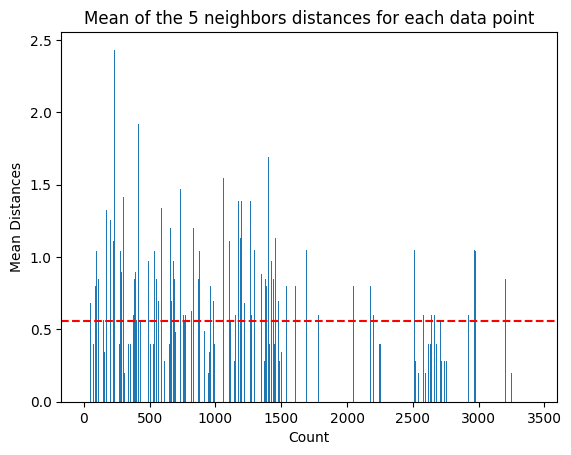

In [338]:
# calculate the mean of the 5 distances and plot a graph that counts
# each row on the X-axis and displays each mean distance on the Y-axis...
dist_means = distances.mean(axis=1)
plt.bar(np.array(range(0, len(y_train))), dist_means)
plt.title('Mean of the 5 neighbors distances for each data point')
plt.xlabel('Count')
plt.ylabel('Mean Distances')

plt.axhline(y = 0.56, color = 'r', linestyle = '--')

In [339]:
# Visually determine cutoff values > 0.56
outlier_index = np.where(dist_means > 0.56)
outlier_index

(array([   6,    7,   10,   15,   17,   19,   21,   25,   27,   28,   29,
          32,   34,   38,   42,   49,   50,   53,   59,   62,   63,   67,
          70,   75,   79,   86,   87,   88,   93,   96,  103,  105,  107,
         111,  114,  116,  118,  122,  124,  125,  133,  146,  147,  148,
         149,  152,  153,  154,  160,  166,  167,  171,  172,  175,  176,
         179,  188,  192,  194,  198,  202,  204,  208,  211,  221,  225,
         227,  228,  229,  230,  231,  233,  234,  255,  256,  258,  259,
         264,  270,  272,  274,  278,  281,  286,  291,  295,  297,  300,
         301,  304,  305,  306,  308,  310,  311,  315,  319,  321,  322,
         323,  326,  328,  330,  331,  332,  334,  335,  336,  337,  345,
         348,  350,  356,  357,  358,  364,  368,  370,  376,  377,  378,
         380,  381,  382,  383,  384,  385,  388,  390,  392,  393,  395,
         396,  398,  399,  400,  402,  403,  404,  405,  409,  415,  416,
         420,  421,  422,  424,  426, 

In [340]:
# Filter outlier values (locate them in the dataframe)...
df_SMOTE = pd.concat([y_train, X_train], axis=1)
outlier_values = df_SMOTE.iloc[outlier_index]
outlier_values

,job_type,work_type,instrumentation,java,aws,communication,crm,kubernetes,healthcare,teamwork,...,leadership,spark,writing,training,cisco,excel,etl,scrum,planning,recruiting
6,Data Analyst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,Business Analyst,0,0,0,0,1,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
10,Senior Business Analyst,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
15,Salesforce Developer,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,Azure Data Engineer,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,Senior Java Software Engineer,2,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3186,Senior Java Software Engineer,2,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3200,Senior Java Software Engineer,2,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3204,Senior Java Software Engineer,2,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# ***Decision Tree***

In [341]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
# y_pred

In [342]:
y_pred2 = clf.predict(X_test2)
y_pred2

array(['Salesforce Developer'], dtype=object)

In [343]:
#tree.plot_tree(clf)

In [344]:
#plt.figure(figsize=(10,10)) # For example, (6, 10) represents a figure size of 6 inches in width and 10 inches in height.
#tree.plot_tree(clf, rounded=True, filled=True, feature_names=X.columns)

In [345]:
x_updated=X.columns.tolist() # Convert x.columns to a list of strings
text_rep=tree.export_text(clf, feature_names=x_updated) # Export the decision tree as text representation
print(text_rep)

|--- java <= 0.50
|   |--- work_type <= 1.50
|   |   |--- accounting <= 0.50
|   |   |   |--- python <= 0.50
|   |   |   |   |--- sql <= 0.50
|   |   |   |   |   |--- communication <= 0.50
|   |   |   |   |   |   |--- agile <= 0.50
|   |   |   |   |   |   |   |--- work_type <= 0.50
|   |   |   |   |   |   |   |   |--- analytics <= 0.50
|   |   |   |   |   |   |   |   |   |--- design <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- organization <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- organization >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- design >  0.50
|   |   |   |   |   |   |   |   |   |   |--- erp <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- erp >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: Business Analyst

In [346]:
# Evaluating DT for Classification...
acc =  clf.score(X_test, y_test)
print(acc)

0.7788649706457925


In [347]:
dt_acc = accuracy_score(y_test, y_pred)
print("DT accuracy:", dt_acc)
dt_accuracy = cross_val_score(clf,X_test,y_test,scoring='accuracy')
print("Cross-Validation Accuracy:", dt_accuracy.mean())
prv = precision_score(y_test,y_pred,average='weighted')
print("Precision:", prv)
f1v = f1_score(y_test,y_pred,average='weighted')
print("F1 Score:", f1v)

names.append('DT')
scores.append(dt_acc)
cross_scores.append(dt_accuracy.mean())
pr.append(prv)
f1.append(f1v)

DT accuracy: 0.7788649706457925
Cross-Validation Accuracy: 0.5557395773843518
Precision: 0.807384713680453
F1 Score: 0.7773652905571757


In [348]:
# Visualize using a heatmap....
from sklearn.metrics import classification_report, confusion_matrix
#importing Seaborn's to use the heatmap
import seaborn as sns

#*********

all_classes = y_train.unique()

# Create an empty confusion matrix of size 105x105 (assuming 105 classes)
conf_matrix = np.zeros((len(all_classes), len(all_classes)))

# Compute confusion matrix using y_test and y_pred
cm = confusion_matrix(y_test, y_pred, labels=all_classes)

# Fill the corresponding part of the empty confusion matrix with computed values
conf_matrix[:cm.shape[0], :cm.shape[1]] = cm

# Convert the confusion matrix to a DataFrame for better readability (optional)
cm = pd.DataFrame(conf_matrix, index=all_classes, columns=all_classes)

cm_int = cm.astype(int)

# Seaborn's heatmap to better visualize the confusion matrix
#plt.figure(figsize = (50,50))
#sns.heatmap(cm_int, annot=True, fmt='d');

print(classification_report(y_test, y_pred))

                                 precision    recall  f1-score   support

            Azure Data Engineer       0.60      0.43      0.50        14
               Business Analyst       0.88      0.50      0.64        46
                   Data Analyst       0.93      0.87      0.90        30
                  Data Engineer       0.90      0.76      0.83        50
                 Data Scientist       0.47      0.64      0.55        14
         Human Resources Intern       0.70      0.64      0.67        11
                 Java Team Lead       0.50      1.00      0.67        14
            Lead .NET Developer       0.81      0.76      0.79        17
         Lead Automation Tester       0.90      0.93      0.92        29
            Lead Java Developer       0.81      0.43      0.57        30
    Lead Java Software Engineer       0.96      1.00      0.98        43
  Lead Test Automation Engineer       0.93      1.00      0.96        13
               PL/SQL Developer       0.79      0.

# ***Logistic Regression***

In [349]:
lr = LogisticRegression()
lr_clf = lr.fit(X_train,y_train)
y_pred=lr_clf.predict(X_test)

lr_acc = accuracy_score(y_test, y_pred)
print("LR accuracy:", lr_acc)
lr_accuracy = cross_val_score(lr_clf,X_test,y_test,scoring='accuracy')
print("Cross-Validation Accuracy:", lr_accuracy.mean())
prv = precision_score(y_test,y_pred,average='weighted')
print("Precision:", prv)
f1v = f1_score(y_test,y_pred,average='weighted')
print("F1 Score:", f1v)

names.append('LR')
scores.append(lr_acc)
cross_scores.append(lr_accuracy.mean())
pr.append(prv)
f1.append(f1v)

LR accuracy: 0.6379647749510763
Cross-Validation Accuracy: 0.5459737292975444
Precision: 0.667844624244878
F1 Score: 0.6314243446233637


In [350]:
y_pred2 = lr_clf.predict(X_test2)
y_pred2

array(['Salesforce Developer'], dtype=object)

In [351]:
# Evaluating LR for Classification...
acc =  lr_clf.score(X_test, y_test)
print(acc)

0.6379647749510763


In [352]:
# Visualize using a heatmap....
from sklearn.metrics import classification_report, confusion_matrix
#importing Seaborn's to use the heatmap
import seaborn as sns

#*********

all_classes = y_train.unique()

# Create an empty confusion matrix of size 105x105 (assuming 105 classes)
conf_matrix = np.zeros((len(all_classes), len(all_classes)))

# Compute confusion matrix using y_test and y_pred
cm = confusion_matrix(y_test, y_pred, labels=all_classes)

# Fill the corresponding part of the empty confusion matrix with computed values
conf_matrix[:cm.shape[0], :cm.shape[1]] = cm

# Convert the confusion matrix to a DataFrame for better readability (optional)
cm = pd.DataFrame(conf_matrix, index=all_classes, columns=all_classes)

cm_int = cm.astype(int)

# Seaborn's heatmap to better visualize the confusion matrix
#plt.figure(figsize = (50,50))
#sns.heatmap(cm_int, annot=True, fmt='d');

print(classification_report(y_test, y_pred))

                                 precision    recall  f1-score   support

            Azure Data Engineer       0.23      0.21      0.22        14
               Business Analyst       0.74      0.50      0.60        46
                   Data Analyst       0.68      0.43      0.53        30
                  Data Engineer       0.69      0.48      0.56        50
                 Data Scientist       0.36      0.36      0.36        14
         Human Resources Intern       0.58      0.64      0.61        11
                 Java Team Lead       0.50      1.00      0.67        14
            Lead .NET Developer       0.59      0.59      0.59        17
         Lead Automation Tester       0.82      0.48      0.61        29
            Lead Java Developer       0.80      0.40      0.53        30
    Lead Java Software Engineer       0.91      1.00      0.96        43
  Lead Test Automation Engineer       0.83      0.77      0.80        13
               PL/SQL Developer       0.65      0.

# ***Random Forest***

In [353]:
rmf = RandomForestClassifier()
rmf_clf = rmf.fit(X_train,y_train)
y_pred=rmf_clf.predict(X_test)

rmf_clf_acc = accuracy_score(y_test, y_pred)
print("RMF accuracy:", rmf_clf_acc)
rmf_clf_acc2 = cross_val_score(rmf_clf,X_train,y_train,scoring="accuracy")
print("Cross-Validation Accuracy:", rmf_clf_acc2.mean())
prv = precision_score(y_test,y_pred,average='weighted')
print("Precision:", prv)
f1v = f1_score(y_test,y_pred,average='weighted')
print("F1 Score:", f1v)

names.append('RF')
scores.append(rmf_clf_acc)
cross_scores.append(rmf_clf_acc2.mean())
pr.append(prv)
f1.append(f1v)

RMF accuracy: 0.7886497064579256
Cross-Validation Accuracy: 0.8120738013662191
Precision: 0.8125998138799578
F1 Score: 0.7861537891667484


In [354]:
y_pred2 = rmf_clf.predict(X_test2)
y_pred2

array(['Salesforce Developer'], dtype=object)

In [355]:
# Evaluating RMF for Classification...
acc =  rmf_clf.score(X_test, y_test)
print(acc)

0.7886497064579256


In [356]:
# Visualize using a heatmap....
from sklearn.metrics import classification_report, confusion_matrix
#importing Seaborn's to use the heatmap
import seaborn as sns

#*********

all_classes = y_train.unique()

# Create an empty confusion matrix of size 105x105 (assuming 105 classes)
conf_matrix = np.zeros((len(all_classes), len(all_classes)))

# Compute confusion matrix using y_test and y_pred
cm = confusion_matrix(y_test, y_pred, labels=all_classes)

# Fill the corresponding part of the empty confusion matrix with computed values
conf_matrix[:cm.shape[0], :cm.shape[1]] = cm

# Convert the confusion matrix to a DataFrame for better readability (optional)
cm = pd.DataFrame(conf_matrix, index=all_classes, columns=all_classes)

cm_int = cm.astype(int)

# Seaborn's heatmap to better visualize the confusion matrix
#plt.figure(figsize = (50,50))
#sns.heatmap(cm_int, annot=True, fmt='d');

print(classification_report(y_test, y_pred))

                                 precision    recall  f1-score   support

            Azure Data Engineer       0.75      0.43      0.55        14
               Business Analyst       0.86      0.54      0.67        46
                   Data Analyst       0.89      0.83      0.86        30
                  Data Engineer       0.88      0.70      0.78        50
                 Data Scientist       0.69      0.64      0.67        14
         Human Resources Intern       0.80      0.73      0.76        11
                 Java Team Lead       0.50      1.00      0.67        14
            Lead .NET Developer       0.82      0.82      0.82        17
         Lead Automation Tester       0.90      0.93      0.92        29
            Lead Java Developer       0.70      0.47      0.56        30
    Lead Java Software Engineer       0.96      1.00      0.98        43
  Lead Test Automation Engineer       0.93      1.00      0.96        13
               PL/SQL Developer       0.71      0.

# ***SVM RBF Kernel***

In [357]:
# Creating an SVM classifier with RBF kernel
rbf_svm = svm.SVC(kernel='rbf')
# Training the model
rbf_svm.fit(X_train, y_train)
# Making predictions on the test data
y_pred = rbf_svm.predict(X_test)

# Calculating the accuracy of the SVM model
rbf_svm_acc = accuracy_score(y_test, y_pred)
print("SVM RBF Kernel accuracy:", rbf_svm_acc)
rbf_svm_acc2 = cross_val_score(rbf_svm,X_train,y_train,scoring="accuracy")
print("Cross-Validation Accuracy:", rbf_svm_acc2.mean())
prv = precision_score(y_test,y_pred,average="weighted")
print("Precision:", prv)
f1v = f1_score(y_test,y_pred,average="weighted")
print("F1 Score:", f1v)

names.append('Rsvm')
scores.append(rbf_svm_acc)
cross_scores.append(rbf_svm_acc2.mean())
pr.append(prv)
f1.append(f1v)

SVM RBF Kernel accuracy: 0.7299412915851272
Cross-Validation Accuracy: 0.7595582132748824
Precision: 0.7523166232230812
F1 Score: 0.7290296545283553


In [358]:
y_pred2 = rbf_svm.predict(X_test2)
y_pred2

array(['Salesforce Developer'], dtype=object)

In [359]:
# Evaluating RMF for Classification...
acc =  rbf_svm.score(X_test, y_test)
print(acc)

0.7299412915851272


In [360]:
# Visualize using a heatmap....
from sklearn.metrics import classification_report, confusion_matrix
#importing Seaborn's to use the heatmap
import seaborn as sns

#*********

all_classes = y_train.unique()

# Create an empty confusion matrix of size 105x105 (assuming 105 classes)
conf_matrix = np.zeros((len(all_classes), len(all_classes)))

# Compute confusion matrix using y_test and y_pred
cm = confusion_matrix(y_test, y_pred, labels=all_classes)

# Fill the corresponding part of the empty confusion matrix with computed values
conf_matrix[:cm.shape[0], :cm.shape[1]] = cm

# Convert the confusion matrix to a DataFrame for better readability (optional)
cm = pd.DataFrame(conf_matrix, index=all_classes, columns=all_classes)

cm_int = cm.astype(int)

# Seaborn's heatmap to better visualize the confusion matrix
#plt.figure(figsize = (50,50))
#sns.heatmap(cm_int, annot=True, fmt='d');

print(classification_report(y_test, y_pred))

                                 precision    recall  f1-score   support

            Azure Data Engineer       0.60      0.43      0.50        14
               Business Analyst       0.72      0.63      0.67        46
                   Data Analyst       0.83      0.63      0.72        30
                  Data Engineer       0.81      0.70      0.75        50
                 Data Scientist       0.73      0.57      0.64        14
         Human Resources Intern       0.78      0.64      0.70        11
                 Java Team Lead       0.50      1.00      0.67        14
            Lead .NET Developer       0.65      0.65      0.65        17
         Lead Automation Tester       0.84      0.72      0.78        29
            Lead Java Developer       0.74      0.47      0.57        30
    Lead Java Software Engineer       0.91      1.00      0.96        43
  Lead Test Automation Engineer       0.93      1.00      0.96        13
               PL/SQL Developer       0.79      0.

# ***Multinomial Naive Bayes***

In [361]:
# Create Multinomial Naive Bayes classifier
mnb = MultinomialNB()
# Fit the classifier to the training data
mnb.fit(X_train, y_train)
# Predict on the test set
y_pred = mnb.predict(X_test)

mnb_acc = accuracy_score(y_test, y_pred)
print("MNB accuracy:", mnb_acc)
mnb_acc2 = cross_val_score(mnb,X_train,y_train,scoring="accuracy")
print("Cross-Validation Accuracy:", mnb_acc2.mean())
prv = precision_score(y_test,y_pred,average="weighted")
print("Precision:", prv)
f1v = f1_score(y_test,y_pred,average="weighted")
print("F1 Score:", f1v)

names.append('MNB')
scores.append(mnb_acc)
cross_scores.append(mnb_acc2.mean())
pr.append(prv)
f1.append(f1v)

MNB accuracy: 0.5146771037181996
Cross-Validation Accuracy: 0.5766023281053819
Precision: 0.5487573644705418
F1 Score: 0.5090448224979897


In [362]:
y_pred2 = mnb.predict(X_test2)
y_pred2

array(['Salesforce Developer'], dtype='<U31')

In [363]:
# Evaluating RMF for Classification...
acc =  mnb.score(X_test, y_test)
print(acc)

0.5146771037181996


In [364]:
# Visualize using a heatmap....
from sklearn.metrics import classification_report, confusion_matrix
#importing Seaborn's to use the heatmap
import seaborn as sns

#*********

all_classes = y_train.unique()

# Create an empty confusion matrix of size 105x105 (assuming 105 classes)
conf_matrix = np.zeros((len(all_classes), len(all_classes)))

# Compute confusion matrix using y_test and y_pred
cm = confusion_matrix(y_test, y_pred, labels=all_classes)

# Fill the corresponding part of the empty confusion matrix with computed values
conf_matrix[:cm.shape[0], :cm.shape[1]] = cm

# Convert the confusion matrix to a DataFrame for better readability (optional)
cm = pd.DataFrame(conf_matrix, index=all_classes, columns=all_classes)

cm_int = cm.astype(int)

# Seaborn's heatmap to better visualize the confusion matrix
#plt.figure(figsize = (50,50))
#sns.heatmap(cm_int, annot=True, fmt='d');

print(classification_report(y_test, y_pred))

                                 precision    recall  f1-score   support

            Azure Data Engineer       0.26      0.43      0.32        14
               Business Analyst       0.67      0.39      0.49        46
                   Data Analyst       0.50      0.37      0.42        30
                  Data Engineer       0.72      0.52      0.60        50
                 Data Scientist       0.31      0.36      0.33        14
         Human Resources Intern       0.29      0.73      0.41        11
                 Java Team Lead       0.47      1.00      0.64        14
            Lead .NET Developer       0.40      0.35      0.38        17
         Lead Automation Tester       0.81      0.45      0.58        29
            Lead Java Developer       0.24      0.13      0.17        30
    Lead Java Software Engineer       0.75      0.70      0.72        43
  Lead Test Automation Engineer       0.56      0.77      0.65        13
               PL/SQL Developer       0.61      0.

# ***Label Encode Y for ANN and LightGBM***

In [365]:
le1 = LabelEncoder()
ann_y_train = le1.fit_transform(y_train)
ann_y_test = le1.transform(y_test)

In [366]:
print( dict(zip(le1.classes_, le1.transform(le1.classes_)))  )

{'Azure Data Engineer': 0, 'Business Analyst': 1, 'Data Analyst': 2, 'Data Engineer': 3, 'Data Scientist': 4, 'Human Resources Intern': 5, 'Java Team Lead': 6, 'Lead .NET Developer': 7, 'Lead Automation Tester': 8, 'Lead Java Developer': 9, 'Lead Java Software Engineer': 10, 'Lead Test Automation Engineer': 11, 'PL/SQL Developer': 12, 'Python Developer': 13, 'Salesforce Developer': 14, 'Senior Analyst': 15, 'Senior Automation Tester': 16, 'Senior Business Analyst': 17, 'Senior Data Engineer': 18, 'Senior Developer': 19, 'Senior Java Software Engineer': 20, 'Senior ReactJS Developer': 21, 'Senior Test Automation Engineer': 22}


# ***ANN***

In [367]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU

model = Sequential()
model.add(Dense(units=64, activation=LeakyReLU(alpha=0.01), input_dim=len(skills)+1))
model.add(Dense(units=32, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(units=16, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(units=8, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(units=len(y_train.unique()), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history=model.fit(X_train, ann_y_train, epochs=400, batch_size=32)

loss, accuracy = model.evaluate(X_test, ann_y_test)
print(f'Test loss: {loss:.4f}')
print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 1/400
108/108 [==============================] - 2s 3ms/step - loss: 3.0803 - accuracy: 0.0692
Epoch 2/400
108/108 [==============================] - 0s 3ms/step - loss: 2.6908 - accuracy: 0.1727
Epoch 3/400
108/108 [==============================] - 0s 3ms/step - loss: 2.1245 - accuracy: 0.3087
Epoch 4/400
108/108 [==============================] - 0s 3ms/step - loss: 1.6768 - accuracy: 0.4500
Epoch 5/400
108/108 [==============================] - 0s 3ms/step - loss: 1.4179 - accuracy: 0.5468
Epoch 6/400
108/108 [==============================] - 0s 3ms/step - loss: 1.2571 - accuracy: 0.6134
Epoch 7/400
108/108 [==============================] - 0s 3ms/step - loss: 1.1516 - accuracy: 0.6641
Epoch 8/400
108/108 [==============================] - 0s 3ms/step - loss: 1.0652 - accuracy: 0.6793
Epoch 9/400
108/108 [==============================] - 0s 3ms/step - loss: 0.9964 - accuracy: 0.6971
Epoch 10/400
108/108 [==============================] - 0s 3ms/step - loss: 0.9444 - accura

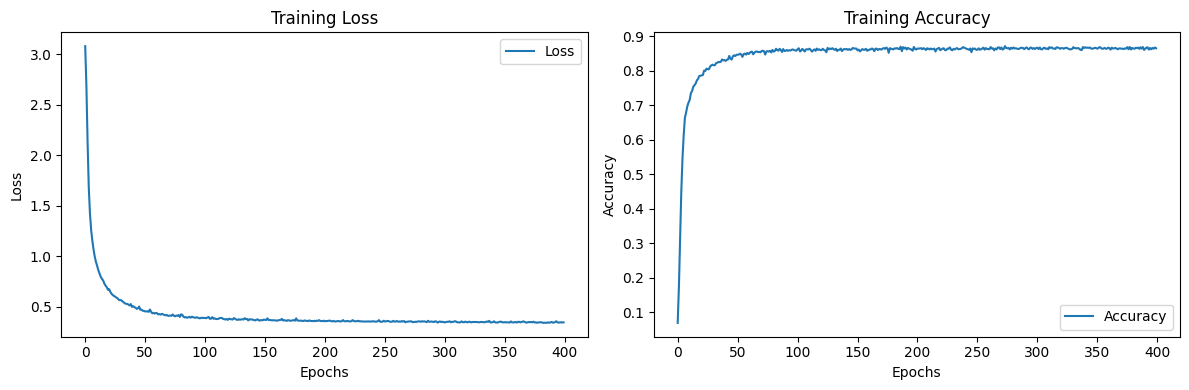

In [368]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

In [369]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                3520      
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 23)                207       
                                                                 
Total params: 6471 (25.28 KB)
Trainable params: 6471 (25.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [370]:
predictions = model.predict(X_test2)
print(predictions[0]) #outputs 398 probability values of the input feature belonging to that class in contrast to other 397 classes

1/1 [==============================] - 0s 72ms/step
[2.2358575e-04 1.9791698e-06 1.6400121e-06 8.2943654e-07 3.0441722e-08
 6.4155752e-06 1.5155266e-27 3.4832196e-05 1.5008340e-18 1.0768050e-16
 1.3982088e-21 1.1414564e-18 5.9993854e-09 3.4700337e-05 9.9967718e-01
 8.1982963e-09 5.8440047e-08 2.2086965e-06 4.0564234e-07 1.2313834e-07
 1.1529143e-16 1.6077554e-05 2.7942443e-13]


In [371]:
for i,val in enumerate(predictions[0]):  #we will consider the class giving the highest probability as our predicted class
    if val==max(predictions[0]):
        print(f"Class {i}")

Class 14


In [372]:
le1.inverse_transform([np.argmax(predictions[0])])

array(['Salesforce Developer'], dtype=object)

In [373]:
pred = model.predict(X_test)
pred

16/16 [==============================] - 0s 1ms/step


array([[2.23585550e-04, 1.97917552e-06, 1.64001835e-06, ...,
        1.15292301e-16, 1.60775999e-05, 2.79425490e-13],
       [0.00000000e+00, 7.38377404e-09, 4.65697359e-14, ...,
        9.99749184e-01, 5.73754855e-32, 0.00000000e+00],
       [3.06487118e-06, 1.11438866e-13, 1.38629677e-10, ...,
        9.12667970e-24, 2.37599539e-04, 3.35411638e-01],
       ...,
       [2.63807330e-23, 3.64473429e-08, 1.63590248e-05, ...,
        1.53862275e-05, 1.73753794e-08, 3.69758047e-18],
       [1.05164369e-36, 1.15605155e-06, 6.82625887e-06, ...,
        9.95869219e-01, 2.17537754e-15, 0.00000000e+00],
       [6.33409922e-11, 1.42612989e-04, 2.96724011e-06, ...,
        4.07475499e-14, 6.80152425e-06, 5.27342670e-29]], dtype=float32)

In [374]:
pred2 = []
for i in range(len(pred)):
  pred2.append(np.argmax(pred[i]))
pred2

[14,
 20,
 16,
 16,
 0,
 2,
 6,
 17,
 14,
 9,
 6,
 3,
 3,
 7,
 22,
 16,
 10,
 16,
 1,
 13,
 2,
 18,
 22,
 2,
 15,
 14,
 18,
 18,
 8,
 10,
 0,
 1,
 7,
 3,
 14,
 6,
 13,
 16,
 20,
 8,
 4,
 10,
 2,
 16,
 11,
 3,
 7,
 10,
 18,
 2,
 10,
 3,
 16,
 16,
 10,
 19,
 14,
 10,
 1,
 15,
 20,
 13,
 16,
 7,
 18,
 6,
 11,
 10,
 11,
 13,
 21,
 3,
 1,
 15,
 21,
 2,
 10,
 18,
 13,
 2,
 19,
 3,
 20,
 13,
 6,
 2,
 21,
 8,
 4,
 2,
 4,
 10,
 3,
 10,
 17,
 3,
 1,
 20,
 10,
 17,
 16,
 1,
 21,
 12,
 3,
 5,
 10,
 16,
 14,
 8,
 9,
 14,
 3,
 8,
 9,
 10,
 19,
 12,
 15,
 22,
 13,
 11,
 11,
 10,
 1,
 22,
 2,
 13,
 10,
 22,
 8,
 6,
 18,
 12,
 17,
 3,
 13,
 21,
 18,
 12,
 7,
 20,
 14,
 1,
 2,
 14,
 8,
 18,
 6,
 2,
 1,
 3,
 8,
 13,
 2,
 8,
 13,
 13,
 2,
 10,
 6,
 0,
 13,
 12,
 17,
 13,
 16,
 7,
 2,
 2,
 2,
 17,
 18,
 16,
 20,
 3,
 22,
 1,
 5,
 13,
 10,
 5,
 15,
 3,
 8,
 2,
 0,
 3,
 15,
 6,
 1,
 1,
 5,
 10,
 16,
 10,
 21,
 10,
 12,
 21,
 14,
 0,
 2,
 9,
 20,
 11,
 6,
 14,
 16,
 8,
 11,
 14,
 1,
 7,
 3,
 8,
 6,
 6,
 10,
 

In [375]:
y_pred = pred2

ann_acc = accuracy_score(ann_y_test, y_pred)
print("ANN accuracy:", ann_acc)
# ann_acc2 = cross_val_score(model,X_train,ann_y_train,scoring="accuracy")
print("Cross-Validation Accuracy:", ann_acc)
prv = precision_score(ann_y_test,y_pred,average="weighted")
print("Precision:", prv)
f1v = f1_score(ann_y_test,y_pred,average="weighted")
print("F1 Score:", f1v)

names.append('ANN')
scores.append(ann_acc)
cross_scores.append(ann_acc)
pr.append(prv)
f1.append(f1v)

ANN accuracy: 0.761252446183953
Cross-Validation Accuracy: 0.761252446183953
Precision: 0.7907337219812711
F1 Score: 0.7575351839337475


# ***LightGBM***

In [376]:
#set the training data
train_data = lgb.Dataset(X_train, label=ann_y_train)

# Set parameters for LGBM classifier
params = {'objective': 'multiclass', 'num_classes': len(y_train.unique()), 'random_state': 42, 'learning_rate': 0.1, 'num_iterations': 1000}

#Create and Train an LGBM classifier
lgb_classifier = lgb.train(params, train_data)

# Predict on test set and evaluate accuracy
y_pred_lgb = lgb_classifier.predict(X_test)
y_pred_lgb

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

array([[3.80535580e-07, 5.34457858e-05, 1.10444447e-09, ...,
        3.79420708e-05, 6.64539862e-04, 4.27762934e-06],
       [7.53176323e-09, 5.01084437e-08, 3.05718806e-05, ...,
        9.99021683e-01, 1.11082091e-07, 9.08284845e-09],
       [6.39869101e-06, 8.28076055e-08, 8.41493936e-06, ...,
        5.13031609e-08, 2.95495381e-02, 9.62685161e-01],
       ...,
       [9.50325004e-07, 1.12910388e-06, 1.10193235e-09, ...,
        3.14884112e-06, 2.27654774e-06, 4.79776476e-06],
       [3.26339991e-08, 2.54052056e-09, 6.77017563e-10, ...,
        9.99832912e-01, 5.40538585e-07, 3.65688473e-08],
       [4.69335173e-06, 4.81230528e-05, 3.62634427e-03, ...,
        8.38282112e-07, 9.56586495e-03, 4.15021765e-07]])

In [377]:
# y_pred_lgb_bin = [1 if x > 0.5 else 0 for x in y_pred_lgb]
pred2 = []
for i in range(len(y_pred_lgb)):
  pred2.append(np.argmax(y_pred_lgb[i]))
y_pred_lgb_bin = pred2

In [378]:
accuracy_lgb = accuracy_score(ann_y_test, y_pred_lgb_bin)
print("Accuracy of LGBM Classifier:",accuracy_lgb)
# accuracy_lgb2 = cross_val_score(lgb_classifier,X_train,ann_y_train,scoring="accuracy")
print("Cross-Validation Accuracy:", accuracy_lgb)
prv = precision_score(ann_y_test,y_pred_lgb_bin,average="weighted")
print("Precision:", prv)
f1v = f1_score(ann_y_test,y_pred_lgb_bin,average="weighted")
print("F1 Score:", f1v)

names.append('LGB')
scores.append(accuracy_lgb)
cross_scores.append(accuracy_lgb)
pr.append(prv)
f1.append(f1v)

Accuracy of LGBM Classifier: 0.7847358121330724
Cross-Validation Accuracy: 0.7847358121330724
Precision: 0.8100921495238823
F1 Score: 0.7831361612559657


# ***Comparing model performances***

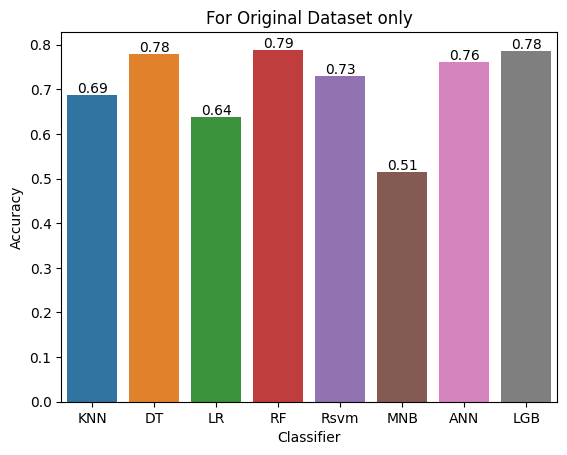

In [379]:
axis = sns.barplot(x = 'Name', y = 'Score', data = pd.DataFrame({'Name': names, 'Score': scores}) )
axis.set(title='For Original Dataset only',xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.2f}'.format(height), ha="center")

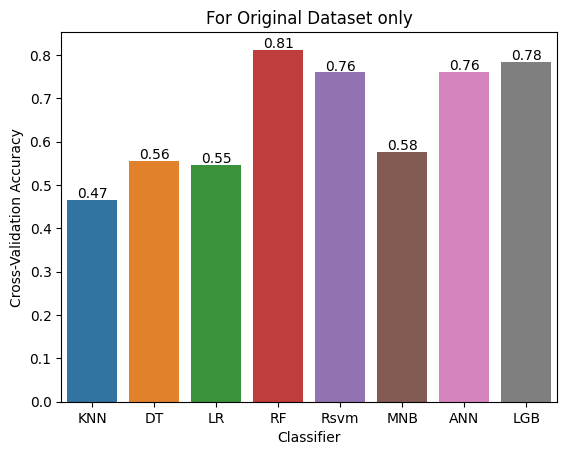

In [380]:
axis = sns.barplot(x = 'Name', y = 'Score', data = pd.DataFrame({'Name': names, 'Score': cross_scores}) )
axis.set(title='For Original Dataset only',xlabel='Classifier', ylabel='Cross-Validation Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.2f}'.format(height), ha="center")

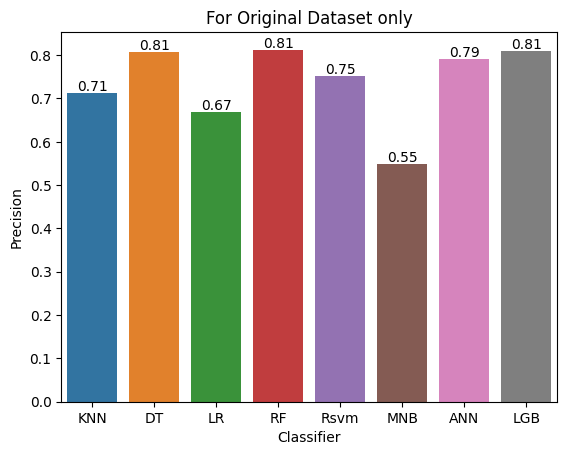

In [381]:
axis = sns.barplot(x = 'Name', y = 'Score', data = pd.DataFrame({'Name': names, 'Score': pr}) )
axis.set(title='For Original Dataset only',xlabel='Classifier', ylabel='Precision')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.2f}'.format(height), ha="center")

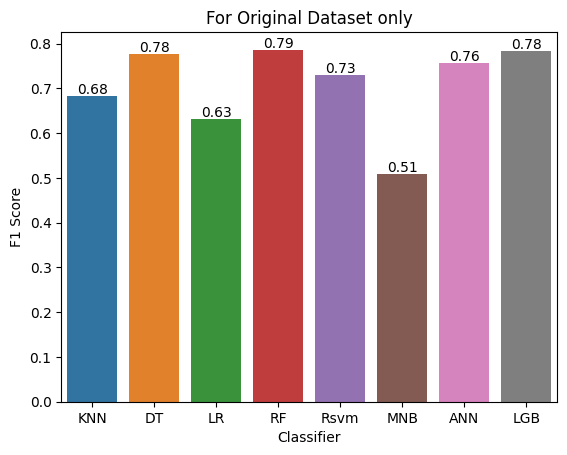

In [382]:
axis = sns.barplot(x = 'Name', y = 'Score', data = pd.DataFrame({'Name': names, 'Score': f1}) )
axis.set(title='For Original Dataset only',xlabel='Classifier', ylabel='F1 Score')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.2f}'.format(height), ha="center")

# ***Downloading PKL Files***

In [390]:
with open('skills.txt', 'w') as file:
    for skill in skills:
        file.write(skill + '\n')
files.download('skills.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [391]:
with open('le.pkl', 'wb') as file:
    pickle.dump(le, file)
files.download("le.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [392]:
with open('ML_model.pkl', 'wb') as file:
    pickle.dump(rmf_clf, file)
files.download("ML_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [393]:
# If ANN is chosen
# with open('le1.pkl', 'wb') as file:
#     pickle.dump(le1, file)
# files.download("le1.pkl")

# ***PLAY SOUND ONCE ALL THE CODES ARE EXECUTED***

In [386]:
from IPython.display import HTML
# Display the HTML element
display(HTML(f"""<audio controls autoplay loop><source src='http://codeskulptor-demos.commondatastorage.googleapis.com/descent/gotitem.mp3' type="audio/mpeg"></audio>"""))